In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from gensim.models import Word2Vec
# from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

Dataset: https://www.kaggle.com/kazanova/sentiment140

In [2]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", header=None, encoding = "ISO-8859-1")
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

In [3]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Select equal number of positives and negatives
SIZE = 100_000
HALF = df.shape[0]//2
df = df[HALF-SIZE//2 : HALF + SIZE//2]
df = df[['target', 'text']]

# Convert 4 (positive sentiment) to 1
df['target'].loc[df['target']==4]=1

In [5]:
df['target'].value_counts()

0    50000
1    50000
Name: target, dtype: int64

#### Preprocessing:

From: https://github.com/francisbautista/cs174/blob/master/Notebooks/L04%20-%20Word2Vec.ipynb

In [6]:
stop = set(stopwords.words('english'))
def preprocess(text):
    text=text.lower()
    text=re.sub('[^0-9a-z]+',' ',text)
    split = text.split()
    stopped = [i for i in split if i not in stop]
    return(stopped)

In [7]:
df['text'] = df['text'].apply(preprocess)

#### Find word embeddings with Word2Vec

In [8]:
model = Word2Vec(vector_size=100,window=5,min_count=30, sg=0, alpha = 0.025)
model.build_vocab(df['text'])

In [9]:
model.train(df['text'], total_examples=model.corpus_count, epochs=20)

(10626670, 15747320)

In [10]:
model.wv['test']

array([ 5.6256479e-01, -6.5644398e-02, -3.6620575e-01,  2.0971662e-01,
       -1.0280254e-01,  1.7736392e-03, -2.3424974e-01, -7.4640214e-01,
       -8.9280659e-01,  2.6503763e-01, -1.1599830e+00,  2.4756449e-01,
        5.4239857e-01,  4.9730119e-01, -3.4450895e-01,  1.1718965e+00,
       -1.4173559e+00, -1.5769085e+00,  1.5187401e+00, -6.2471223e-01,
       -6.8684548e-01,  1.3039958e+00,  5.3366131e-01,  4.2881280e-01,
        9.1651690e-01,  1.8119851e-01, -6.4959985e-01, -7.3818880e-01,
       -5.5283481e-01, -1.3477907e+00,  1.8017404e+00, -5.6528570e-03,
       -5.3209174e-01,  3.8348410e-01,  1.4644880e+00,  1.3866477e-01,
       -1.8736236e-01, -1.3223215e+00,  1.4197987e+00,  6.2105578e-01,
        6.0636562e-01, -4.4669566e-01, -1.0377866e+00,  2.6760966e-01,
       -1.2374262e+00, -1.7942015e+00,  1.4410255e+00,  8.3428943e-01,
        9.1442889e-01,  6.1276883e-01, -7.5289750e-01,  2.8691834e-01,
       -1.4383949e-01,  8.2572609e-01,  2.8765848e-01,  1.4102911e+00,
      

In [11]:
model.wv.most_similar('test')

[('exam', 0.7155084013938904),
 ('math', 0.6561870574951172),
 ('maths', 0.6191507577896118),
 ('essay', 0.6005351543426514),
 ('study', 0.5496167540550232),
 ('tests', 0.5337419509887695),
 ('report', 0.5098921060562134),
 ('classes', 0.4971778094768524),
 ('exams', 0.4894334375858307),
 ('lesson', 0.4881514310836792)]

#### Get avg. vector for each tweet

In [12]:
# http://yaronvazana.com/2018/09/20/average-word-vectors-generate-document-paragraph-sentence-embeddings/

def get_avg_vec(list_of_words, model=None):
    words = [word for word in list_of_words if word in model.wv]
    
    if len(words) > 0:
        res = np.mean(model.wv[words], axis=0)
    else:
        res = np.zeros(model.vector_size)
    assert res.shape == (100,)
    return res

In [13]:
df['avg_vec'] = df['text'].apply(get_avg_vec, model=model)

In [14]:
df.reset_index(drop=True, inplace=True)
df

,target,text,avg_vec
0,0,"[opotopo, small, slip, tryfan, weeks, back, fe...","[-0.06332786, 0.55731434, -0.001595731, -0.407..."
1,0,"[idristwilight, post, han, want, great, still,...","[-0.13186751, 0.68496656, -0.63879186, 0.43308..."
2,0,"[rose, 7, ohh, poor, jan, please, tell, cans, ...","[0.2308696, 0.44366634, 0.2612708, 0.36194652,..."
3,0,"[finally, home, work, looong, day, monday]","[0.49362236, 0.49980083, -0.4381346, -0.137553..."
4,0,"[im, sad, 4, chantelle, tom]","[0.13369168, 0.27605462, -0.5643316, 0.0155861..."
...,...,...,...
99995,1,"[need, 8, followers, compleate, 1000, follow, ...","[-0.5362505, -0.043044843, -0.57906324, -0.236..."
99996,1,"[knew, explain, something, friend, said, star,...","[0.16625868, 0.25555652, -0.15221718, -0.44694..."
99997,1,"[done, tweeting, til, tomorrow]","[0.5272579, 0.0430543, 0.021822512, -0.6782348..."
99998,1,"[cmozilo, act, ii, set, pretty, breath, taking...","[0.20755321, 0.15890639, -0.084227555, 0.45783..."


#### Split into train, test, validation sets

* 70% = training
* 15% = test
* 15% = validation

Shuffle the dataset:

In [15]:
df_shuffled = df.sample(frac=1)
df_shuffled.reset_index(inplace=True, drop=True)

In [16]:
train_set = df_shuffled.iloc[:70_000]
test_set = df_shuffled.iloc[70_000:85_000]
val_set = df_shuffled.iloc[85_000:]

X_train = train_set['avg_vec'].to_numpy().reshape(-1, 1)
y_train = train_set['target'].to_numpy()

X_test = test_set['avg_vec'].to_numpy().reshape(-1, 1)
y_test = test_set['target']

X_val = val_set['avg_vec'].to_numpy().reshape(-1, 1)
y_val = val_set['target']

In [17]:
X_train = np.concatenate(np.concatenate(X_train, axis=0), axis=0).reshape(-1, 100)
X_test = np.concatenate(np.concatenate(X_test, axis=0), axis=0).reshape(-1, 100)
X_val = np.concatenate(np.concatenate(X_val, axis=0), axis=0).reshape(-1, 100)

In [18]:
X_train.shape

(70000, 100)

#### Classify with RandomForest

In [19]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

In [20]:
pred = forest.predict(X_test)

In [21]:
pd.Series(pred).value_counts()

0    7509
1    7491
dtype: int64

In [22]:
sum(pred == np.array(y_test)) / len(y_test)

0.7306666666666667

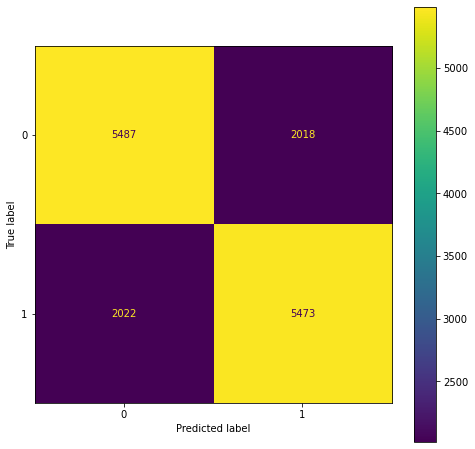

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(forest, X_test, y_test, ax=ax)
plt.show()